# Plot subhalos

In [18]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from simulation.wrapper import augmented_data
from simulation.units import M_s

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

## Make data

In [4]:
imgs, t_xz, log_r_xz, latents = augmented_data(
    n_calib=150., beta=-1.9, n_images=12, sim_mvgauss_file="../simulation/data/sim_mvgauss.npz"
)

17:19 simulation.wrapper   INFO    Simulating image 1 / 12
17:19 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:19 simulation.populatio DEBUG   Subhalo population:
17:19 simulation.populatio DEBUG     n_calib = 150.0
17:19 simulation.populatio DEBUG     beta = -1.9
17:19 simulation.populatio DEBUG     alpha = 1.54729171367e-71
17:19 simulation.populatio DEBUG     n_sub_tot = 16424.7107428
../simulation/profiles.py:101: RuntimeWarning: invalid value encountered in sqrt
  np.arctan(np.sqrt(x ** 2 - 1)) / (np.sqrt(x ** 2 - 1))))
../simulation/profiles.py:100: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x == 1, 1, np.where(x < 1, np.arctanh(np.sqrt(1 - x ** 2)) / (np.sqrt(1 - x ** 2)),
17:19 simulation.populatio DEBUG     f_sub = 0.0149061783285
17:19 simulation.populatio DEBUG     n_sub_roi = 246
17:19 simulation.populatio DEBUG     m_sub: [  4.60409214e+70   1.83288988e+70   3.30527485e+70   3.32948577e+70
   1.42634479e+70   2.14391353e+70   1.73064537

17:20 simulation.wrapper   INFO    Simulating image 3 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.54729171367e-71
17:20 simulation.populatio DEBUG     n_sub_tot = 2911.91374738
17:20 simulation.populatio DEBUG     f_sub = 0.013722817711
17:20 simulation.populatio DEBUG     n_sub_roi = 40
17:20 simulation.populatio DEBUG     m_sub: [  1.03328405e+72   1.17469117e+70   4.81762072e+70   2.98604419e+70
   3.14328912e+70   1.34825582e+72   1.63783458e+71   1.49182674e+70
   2.75347876e+70   8.65925517e+70   3.58073881e+70   1.74122938e+70
   1.34634557e+70   1.20331067e+70   1.91896494e+70   3.58540831e+70
   5.01976951e+70   3.63061867e+70   3.42900263e+71   1.02019491e+71
   1.55065309e+70   1.51459024e+71   1.53327549e+70   3.14934935e+70
   5.12699151e+70   1.57628

17:20 simulation.wrapper   INFO    Simulating image 6 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.54729171367e-71
17:20 simulation.populatio DEBUG     n_sub_tot = 134032.266002
17:20 simulation.populatio DEBUG     f_sub = 0.0401743552673
17:20 simulation.populatio DEBUG     n_sub_roi = 5575
17:20 simulation.populatio DEBUG     m_sub: [  1.12866752e+70   6.21333606e+70   1.34112858e+70 ...,   1.54157413e+71
   1.21320035e+70   1.25209160e+70]
17:20 simulation.wrapper   INFO    Simulating image 7 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.5472

17:20 simulation.wrapper   INFO    Simulating image 8 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.54729171367e-71
17:20 simulation.populatio DEBUG     n_sub_tot = 38704.4922936
17:20 simulation.populatio DEBUG     f_sub = 0.034442413994
17:20 simulation.populatio DEBUG     n_sub_roi = 1347
17:20 simulation.populatio DEBUG     m_sub: [  2.41149486e+71   1.13432643e+70   1.32460189e+70 ...,   1.11246809e+71
   1.51710710e+70   4.21270264e+71]
17:20 simulation.wrapper   INFO    Simulating image 9 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.54729

17:20 simulation.wrapper   INFO    Simulating image 10 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.54729171367e-71
17:20 simulation.populatio DEBUG     n_sub_tot = 34698.788573
17:20 simulation.populatio DEBUG     f_sub = 0.0388467667891
17:20 simulation.populatio DEBUG     n_sub_roi = 1311
17:20 simulation.populatio DEBUG     m_sub: [  5.49467945e+70   4.01829896e+70   1.53673719e+70 ...,   3.94853983e+70
   1.87731353e+72   1.23892192e+70]
17:20 simulation.wrapper   INFO    Simulating image 11 / 12
17:20 simulation.wrapper   DEBUG   Input params: 150.0, -1.9
17:20 simulation.populatio DEBUG   Subhalo population:
17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.547

17:20 simulation.populatio DEBUG     n_calib = 150.0
17:20 simulation.populatio DEBUG     beta = -1.9
17:20 simulation.populatio DEBUG     alpha = 1.54729171367e-71
17:20 simulation.populatio DEBUG     n_sub_tot = 568.344015208
17:20 simulation.populatio DEBUG     f_sub = 0.0184529105023
17:20 simulation.populatio DEBUG     n_sub_roi = 11
17:20 simulation.populatio DEBUG     m_sub: [  3.75693855e+70   1.29834609e+70   2.05138562e+70   5.05747720e+70
   1.08943964e+71   1.95273070e+70   4.23177722e+70   2.87324484e+70
   1.58173512e+70   1.58207037e+70   9.30878994e+70]
../simulation/wrapper.py:112: RuntimeWarning: overflow encountered in double_scalars
  sim.joint_log_probs[i_theta + 1] - sim.joint_log_probs[0]) - inverse_r_xz) ** 2.0
17:20 simulation.wrapper   WARNING Large uncertainty: log r(x,z) = -445.675862163 +/- inf


In [16]:
np.mean(latents[2][0])

3.4442801727109484e+71

## Plot subhalos

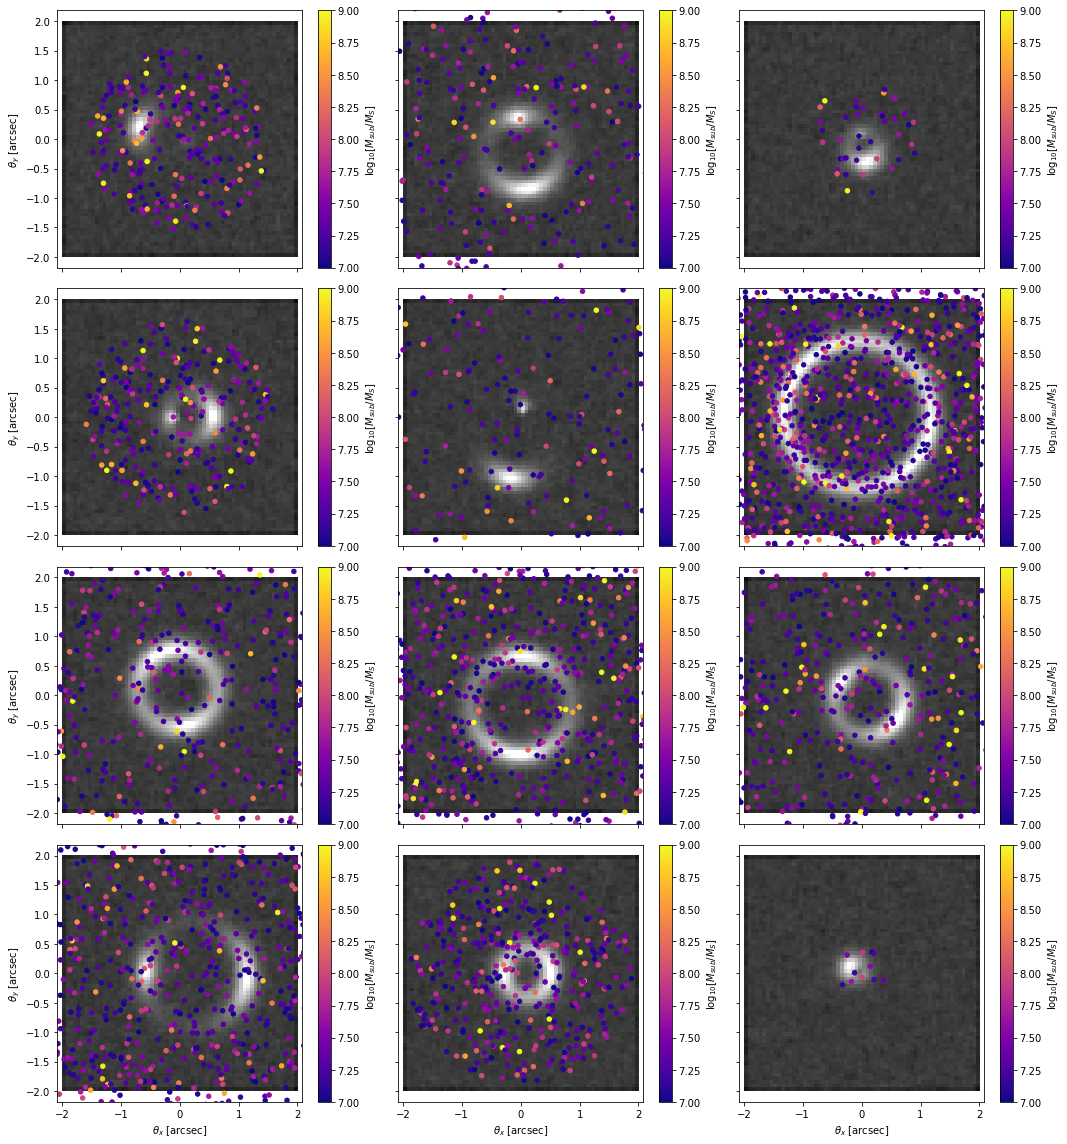

In [28]:
plt.figure(figsize=(15,16))

for i in [9,10,11,0,3,6,1,2,4,5,7,8]:
    if i == 9:
        ax_y = plt.subplot(4,3,i+1)
        ax_x = ax_y
    elif i in [10,11]:
        ax_x = plt.subplot(4,3,i+1, sharey=ax_y)
    elif i in [0,3,6]:
        ax_y = plt.subplot(4,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(4,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(
        np.log10(imgs[i]),
        vmin=2.2,
        vmax=3.1,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        latents[i][:,1],
        latents[i][:,2],
        s=20.,
        c=np.log10(latents[i][:,0] / (M_s)),
        cmap="plasma",
        vmin=7.,
        vmax=9.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)

    if i in [9,10,11]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    if i in [0,3,6,9]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    cbar.set_label(r'$\log_{10} [M_{sub} / M_S]$')
    
    
plt.tight_layout()
plt.savefig("../figures/subhalos.pdf")